## **Import library**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

## **Load data**





In [2]:
train_df = pd.read_csv("https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/01.%20Machine%20Learning/04.%20Week%204/Datasets/FeatureEngineering/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/01.%20Machine%20Learning/04.%20Week%204/Datasets/FeatureEngineering/test.csv")

train_df["is_train"] = True
test_df["is_train"] = False
test_df["SalePrice"] = np.nan

full_df = pd.concat([train_df, test_df], ignore_index=True)

## **Imputasi data kosong**
> * Mendeteksi fitur kategorikal dan numerik.
* Mengisi nilai kosong:
  Kategorikal → isi dengan modus (yang paling sering muncul)
  Numerikal → isi dengan median

In [3]:
categorical_features = full_df.select_dtypes(include=["object"]).columns
numerical_features = full_df.select_dtypes(include=[np.number]).columns

full_df[categorical_features] = SimpleImputer(strategy="most_frequent").fit_transform(full_df[categorical_features])
full_df[numerical_features] = SimpleImputer(strategy="median").fit_transform(full_df[numerical_features])


## **EDA + Visualisasi**
> EDA (Exploratory Data Analysis) untuk mengenali pola dan hubungan antar fitur



In [4]:
eda_df = full_df[full_df["is_train"] == True]

## **Distribusi SalePrice**

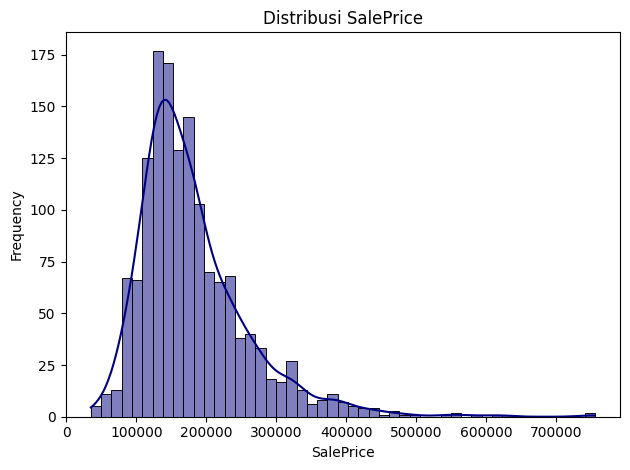

In [5]:
sns.histplot(eda_df["SalePrice"], kde=True, color="navy")
plt.title("Distribusi SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## **Korelasi fitur numerik**

<ipython-input-6-74ae700d5131>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette="viridis")


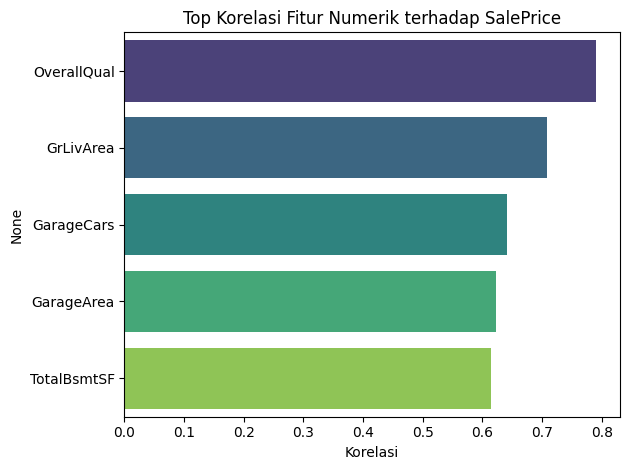

In [6]:
corr_matrix = eda_df[numerical_features].corr()
top_corr_features = corr_matrix["SalePrice"].sort_values(ascending=False)[1:6]

sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette="viridis")
plt.title("Top Korelasi Fitur Numerik terhadap SalePrice")
plt.xlabel("Korelasi")
plt.tight_layout()
plt.show()


## **Feature Engineering**
> * Encoding fitur kategorikal menjadi angka (one-hot encoding), karena model ML hanya bisa bekerja dengan angka.
* Standardisasi fitur numerikal agar skala semua fitur seimbang (khususnya untuk KNN).
* Setelah bersih & diproses → pisahkan lagi jadi train_final dan test_final.



In [7]:
# Encode kategorikal
full_df = pd.get_dummies(full_df, columns=categorical_features, drop_first=True)

In [8]:
# Normalisasi numerik
scaler = StandardScaler()
full_df[numerical_features] = scaler.fit_transform(full_df[numerical_features])

In [9]:
# Pisahkan kembali train dan test
train_final = full_df[full_df["is_train"] == True].drop(columns=["is_train"])
test_final = full_df[full_df["is_train"] == False].drop(columns=["is_train", "SalePrice"])

## **Split dataset**
> * Memisahkan fitur (X) dan target (y).
* Membagi data training menjadi dua bagian:
  * X_train, y_train → untuk melatih model
  * X_val, y_val → untuk mengevaluasi performa model (tanpa menyentuh data test)





In [10]:
X = train_final.drop(columns=["SalePrice"])
y = train_final["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## **Train Models**
> * Mencari kombinasi parameter terbaik untuk Decision Tree
* GridSearchCV secara otomatis mengevaluasi dengan 5-fold CV




In [11]:
param_grid = {
    "max_depth": [3, 5, 7, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2', verbose=1)

## **Evaluasi Model Terbaik**

In [12]:
# Model terbaik
best_tree = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred = best_tree.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("\n=== Decision Tree (Optimized) ===")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10}

=== Decision Tree (Optimized) ===
MSE  : 0.5076
RMSE : 0.7125
R²   : 0.7859


## **Cek overfitting**


> * Membandingkan performa model di data train dan validasi.
* Jika model terlalu bagus di train tapi buruk di validasi → overfitting
* Diukur dengan R² score, jika perbedaan terlalu jauh → kemungkinan overfitting



In [13]:
print(">> Overfitting Check (Decision Tree):")
y_train_pred = models["Decision Tree"].predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, models["Decision Tree"].predict(X_val))

print(f"Train R² : {train_r2:.4f}")
print(f"Valid R² : {val_r2:.4f}")
print("Gap:", abs(train_r2 - val_r2))

>> Overfitting Check (Decision Tree):


NameError: name 'models' is not defined

# **Penjelasan Persamaan Matematika**

## **1. Mean Squared Error (MSE)**

  Rumus :$$
  MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$
   * Rata-rata dari kuadrat selisih antara nilai sebenarnya ($y_i$) dan prediksi model ($\hat{y}_i$).
   * Mengukur seberapa besar kesalahan model. Semakin kecil MSE, semakin baik model.

## **2. Root Mean Squared Error (RMSE)**

Rumus :$$
RMSE = \sqrt{MSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$
   * Akar dari MSE. Memberikan interpretasi error dalam satuan yang sama seperti target asli (SalePrice).

## **3. R-squared (R²)**

Rumus :$$
R^2 = 1 - \frac{ \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }{ \sum_{i=1}^{n} (y_i - \bar{y})^2 }
$$

   * Menunjukkan seberapa besar variasi target (SalePrice) bisa dijelaskan oleh model.
    * Nilai 1 = sempurna
    * Nilai 0 = tidak lebih baik dari rata-rata
    * Nilai < 0 = model lebih buruk dari rata-rata

## **Cek Overfitting**
    
Rumus Evaluasi Overfitting:
$$
\text{Gap} = \left| R^2_{\text{train}} - R^2_{\text{val}} \right|
$$

   * Deteksi apakah model overfitting
   * Jika selisih besar, model terlalu cocok dengan data trai
   * Idealnya, R² train dan validasi tidak berbeda jauh